In [7]:
import numpy as np
from numba import njit
import itertools
import ray

In [13]:
ray.init()

2020-05-19 03:09:28,268	INFO resource_spec.py:212 -- Starting Ray with 5.81 GiB memory available for workers and up to 2.91 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-19 03:09:28,676	INFO services.py:1170 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.202',
 'raylet_ip_address': '192.168.1.202',
 'redis_address': '192.168.1.202:54604',
 'object_store_address': '/tmp/ray/session_2020-05-19_03-09-28_258568_8785/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-05-19_03-09-28_258568_8785/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-05-19_03-09-28_258568_8785'}

In [19]:
n_x_grids = 64
n_y_grids = 64
grid_width = 100
grid_height = 100

In [20]:
def grid_range(begin, end, n_grids):
    ih, it = itertools.tee(np.linspace(begin, end, n_grids + 1))
    next(it)
    return ((h,t) for h,t in zip(ih, it))

@ray.remote
def mandelbrot(c, n = 32, th = 200):
    z = 1j * np.zeros(c.shape)
    r = np.zeros(c.shape)
    for i in range(n):
        mask = np.abs(z) <= th
        z += (z * z + c - z) * mask.astype(np.int)  
        r[mask] = i
    # make smooth
    return r - np.log2(np.log2(np.abs(z) + 1))

def rendering(n_xg, n_yg, gw, gh):
    res = []
    xs = grid_range(-2, 1, n_xg)
    ys = grid_range(-1, 1, n_yg)
    for ((xb, xe), (yb, ye)) in itertools.product(xs, ys):
        x, y = np.meshgrid(np.linspace(xb, xe, gw), np.linspace(yb, ye, gh))
        c = x + 1j * y
        res.append(mandelbrot.remote(c))
    res = ray.get(res)
    return np.concatenate(np.concatenate(np.array(res).reshape(n_yg, n_xg, gh, gw), axis=2),axis=0)

In [21]:
img = rendering(n_x_grids, n_y_grids, grid_width, grid_height)

(pid=8805) /Users/argon/miniconda3/envs/py36/lib/python3.6/site-packages/ray/workers/default_worker.py:15: RuntimeWarning: divide by zero encountered in log2
(pid=8805)   "--node-ip-address",
(pid=8807) /Users/argon/miniconda3/envs/py36/lib/python3.6/site-packages/ray/workers/default_worker.py:15: RuntimeWarning: divide by zero encountered in log2
(pid=8807)   "--node-ip-address",
(pid=8803) /Users/argon/miniconda3/envs/py36/lib/python3.6/site-packages/ray/workers/default_worker.py:15: RuntimeWarning: divide by zero encountered in log2
(pid=8803)   "--node-ip-address",
(pid=8806) /Users/argon/miniconda3/envs/py36/lib/python3.6/site-packages/ray/workers/default_worker.py:15: RuntimeWarning: divide by zero encountered in log2
(pid=8806)   "--node-ip-address",


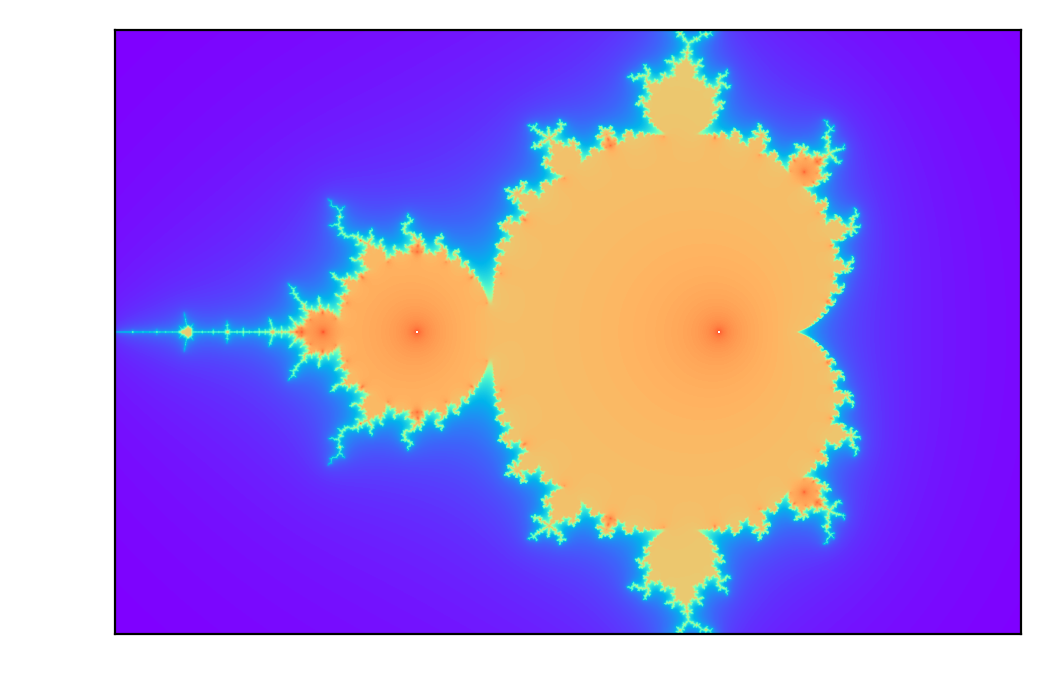

In [23]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.imshow(img, cmap='rainbow', interpolation='bilinear', extent=[-2, 1, -1, 1])
plt.xticks(color='None')
plt.yticks(color='None')
plt.tick_params(length=0)
plt.show()